# 1.0 Modelo para Detecção de Diabetes

O objetivo desse é a elaboração de um modelo capaz de prever se um paciente possui ou não diabetes, baseado em certas medições. Ou seja, temos um problema de classificação binária.

O modelo será baseado em DADOS históricos, sendo que esses dados originalmente pertence ao National Institute of Diabetes and Digestive and Kidney Diseases. Podem ser baixados através do link: https://www.kaggle.com/uciml/pima-indians-diabetes-database.

Significado de cada feature no dataset:

1. Pregnancies:              Number of times pregnant
2. Glucose:                  Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. BloodPressure:            Diastolic blood pressure (mmHg)
4. SkinThickness:            Triceps skin fold thickness (mm)
5. Insulin:                  2-Hour serum insulin (mu U/ml)
6. BMI:                      Body mass index (weight in kg/(height in m)²)
7. DiabetesPedigreeFunction: Diabetes pedigree function
8. Age:                      Age (years)
9. Outcome:                 Class variable (0 or 1)

# 2.0 Módulos

In [1]:
# módulos utilizados:

# ignorar warnings.
import warnings
warnings.filterwarnings('ignore')

# manipulação de dados:
import pandas as pd
import numpy as np

# visualização:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# split do dataset em dados de treino e teste:
from sklearn.model_selection import train_test_split

# pré processamento dos dados:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# algoritmos de machine learning:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# otimização
from sklearn.model_selection import RandomizedSearchCV

# metricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# 3.0 Funções

Funções que serão utilizadas ao decorrer da criação do modelo.

In [2]:
# criar e imprimir displot.    
def displot_stats(df, nome):
    # criar um novo dataset.
    stats = df[df[nome] > 0][[nome, 'Outcome']]
    
    # recolher estatísticas para os pacientes com diabetes.
    stats_true = stats[stats.Outcome == 1][nome].describe()
    
    # recolher estatísticas para os pacientes sem diabetes.
    stats_false = stats[stats.Outcome == 0][nome].describe()
    
    # agrupar em um dataset.
    stats_concat = pd.concat([stats_true, stats_false], axis = 1)
    stats_concat.columns = ['Com Diabetes', 'Sem Diabetes']
    
    # gráfico da distribuição.
    sns.displot(stats, x = nome, hue = 'Outcome', kind = 'kde', fill = True, height = 6)
    plt.show()
    
    # imprimir as estatísticas.
    print(stats_concat)
    
# imputar as médias nos zeros.    
def medias(df):
    mean_true1 = df[(df.Glucose > 0) & (df.Outcome == 1)]['Glucose'].mean()
    mean_false1 = df[(df.Glucose > 0) & (df.Outcome == 0)]['Glucose'].mean()
    df.loc[(df.Glucose == 0) & (df.Outcome == 1), 'Glucose'] = mean_true1
    df.loc[(df.Glucose == 0) & (df.Outcome == 0), 'Glucose'] = mean_false1

    mean_true2 = df[(df.BloodPressure > 0) & (df.Outcome == 1)]['BloodPressure'].mean()
    mean_false2 = df[(df.BloodPressure > 0) & (df.Outcome == 0)]['BloodPressure'].mean()
    df.loc[(df.BloodPressure == 0) & (df.Outcome == 1), 'BloodPressure'] = mean_true2
    df.loc[(df.BloodPressure == 0) & (df.Outcome == 0), 'BloodPressure'] = mean_false2

    mean_true3 = df[(df.SkinThickness > 0) & (df.Outcome == 1)]['SkinThickness'].mean()
    mean_false3 = df[(df.SkinThickness > 0) & (df.Outcome == 0)]['SkinThickness'].mean()
    df.loc[(df.SkinThickness == 0) & (df.Outcome == 1), 'SkinThickness'] = mean_true3
    df.loc[(df.SkinThickness == 0) & (df.Outcome == 0), 'SkinThickness'] = mean_false3

    mean_true4 = df[(df.Insulin > 0) & (df.Outcome == 1)]['Insulin'].mean()
    mean_false4 = df[(df.Insulin > 0) & (df.Outcome == 0)]['Insulin'].mean()
    df.loc[(df.Insulin == 0) & (df.Outcome == 1), 'Insulin'] = mean_true4
    df.loc[(df.Insulin == 0) & (df.Outcome == 0), 'Insulin'] = mean_false4

    mean_true4 = df[(df.BMI > 0) & (df.Outcome == 1)]['BMI'].mean()
    mean_false4 = df[(df.BMI > 0) & (df.Outcome == 0)]['BMI'].mean()
    df.loc[(df.BMI == 0) & (df.Outcome == 1), 'BMI'] = mean_true4
    df.loc[(df.BMI == 0) & (df.Outcome == 0), 'BMI'] = mean_false4
    
    return df    

# treinamento dos modelos.
def fit_modelos(modelos, x_treino, y_treino, x_teste, y_teste):
    # treinamento
    acuracia = []

    for nome, modelo in modelos:
        modelo.fit(x_treino, y_treino)
        acc = round(100 * modelo.score(x_teste, y_teste), 2)
        acuracia.append((nome, acc))    

    data = pd.DataFrame(acuracia).T

    new_header = data.iloc[0]
    data = data[1:]
    data.columns = new_header
    
    return data

# concatenar os resultados do módelo e calculas as médias
def concat_results(result_bruto, result_sem_zeros, result_medias):
    data = pd.concat([result_bruto, result_sem_zeros, result_medias])
    data['MEDIAS'] = round(data.mean(axis = 1), 2)
    data = data.append({'RF'    : round(data['RF'].mean(),     2),
                        'LR'    : round(data['LR'].mean(),     2),
                        'LDA'   : round(data['LDA'].mean(),    2),
                        'NB'    : round(data['NB'].mean(),     2),
                        'KNN'   : round(data['KNN'].mean(),    2),
                        'SVM'   : round(data['SVM'].mean(),    2),
                        'XGB'   : round(data['XGB'].mean(),    2),
                        'MEDIAS': round(data['MEDIAS'].mean(), 2)}, ignore_index=True)
    
    data.index = ['Dados Bruto', 'Sem Zeros', 'Com Médias', 'Médias']
    
    return data

# aplicando normalização com MinMaxScaler
def min_max_scaler(x):
    norm = MinMaxScaler(feature_range = (0, 1))
    x = norm.fit_transform(x)
    return x

# aplicar a normalização com normalizer
def normalizer(x):
    norm = Normalizer().fit(x_treino)
    x = norm.transform(x)
    return x

# aplicar padronização
def standarization(x):
    norm = StandardScaler().fit(x)
    x = norm.transform(x)
    return x

# 4.0 Análise Exploratória dos Dados

In [3]:
# importando o dataset.
df = pd.read_csv('pima-data.csv')
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [4]:
# procurando por missing values no dataset e checando os tipos de cada feature.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# pricipais estatísticas das features.
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
nomes = list(df.columns[1:8])
for nome in nomes:
    size = df[df[nome] == 0][nome].size
    print('Quantidade de zeros em "{}": {}.'.format(nome, size))

Quantidade de zeros em "Glucose": 5.
Quantidade de zeros em "BloodPressure": 35.
Quantidade de zeros em "SkinThickness": 227.
Quantidade de zeros em "Insulin": 374.
Quantidade de zeros em "BMI": 11.
Quantidade de zeros em "DiabetesPedigreeFunction": 0.
Quantidade de zeros em "Age": 0.


O dataset possui 768 observações e 9 colunas, sendo 8 colunas preditoras e uma coluna target. Os tipos dos dados foram importados corretamente, conforme as informações que cada coluna se prestou a indicar.

Entretanto, passando pelas linhas e colunas, foi possível encontrar features que apresentam alguns valores zerados. Podemos levantar algumas hipóteses para isso ter acontecido: esses dados não foram recolhidos ou não foram repassados corretamente para o dataset.

Para resolver esse problema irei imputar alguns valores com base em alguns critérios. Mas vou fazer esse procedimento previamente a seleção de variáveis.

In [7]:
# correlação entre as features.
cor = df.corr()
cor

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


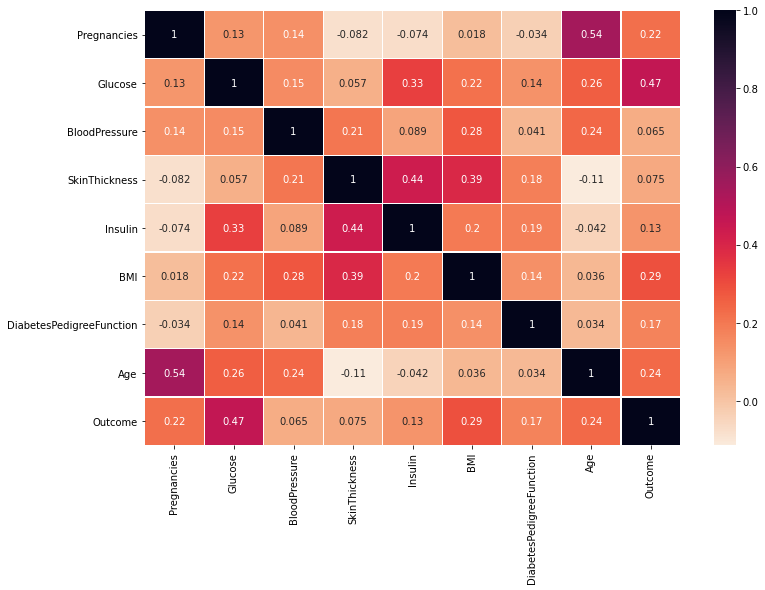

In [8]:
# heatmap da correlação.
plt.figure(figsize = (12, 8))
sns.heatmap(cor, cmap = 'rocket_r', linewidths = 0.3, annot = True)
plt.show()

O dataset possui correlações fracas entre as variáveis. Dentre as correlações encontradas, as que possuem maior grau de correlação é: número de gravidez e idade, glicemia e insulina, Dobra Cutânea Triciptal e insulina e Dobra Cutânea Triciptal e IMC.

Apesar da correlação indicar o grau entre o relacionamento entre duas variáveis, esta não implica em causalidade.

## 4.1 Glicemia

A glicemia é a concentração de glicose no sangue ou mais precisamente no plasma.

O nosso corpo transforma alguns dos hidratos de carbono ingeridos em glicose e a glicemia é o nível de glicose presente no nosso sangue. Ou seja, quando comemos muito, a glicemia aumenta, ao passo que quando comemos pouco, esta mantém-se baixa. 

Mede-se a glicemia através da confirmação dos sinais e sintomas clássicos da glicemia em jejum (exame de sangue onde são verificadas as taxas de glicose no sangue) e do teste padronizado de tolerância à glicose (TTG).

Estes critérios diagnosticados estão baseados nas recomendações da comunidade médico-científica atual:

* Normal: Abaixo de 100 mg/dL;
* Intolerância à glicose: jejum de 111 a 125 mg/dL; 2 horas após 75g de glicose: de 141 a 199 mg/dL;
* Diabetes melitus: jejum maior que 126 mg/dL; 2 horas após 75g de glicose: maior que 200 mg/dL.

Tanto a média quanto a mediana para os sem diabetes é ligeiramente inferior aos pacientes que possuem diabetes. A correlação entre glicemia e diabetes é moderada fraca (0.47).

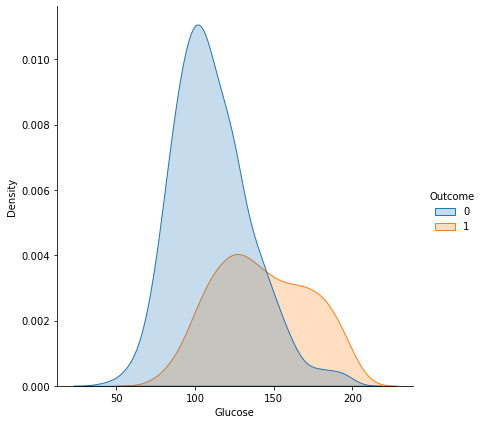

       Com Diabetes  Sem Diabetes
count    266.000000    497.000000
mean     142.319549    110.643863
std       29.599199     24.776906
min       78.000000     44.000000
25%      119.000000     93.000000
50%      140.000000    107.000000
75%      167.000000    125.000000
max      199.000000    197.000000


In [9]:
displot_stats(df, 'Glucose')

## 4.2 Pressão Sanguínea Diastólica

Pressão arterial diastólica (PAD) é o menor valor verificado durante a aferição de pressão arterial. Exemplo: 120x80; em que 120 refere-se à pressão arterial sistólica e 80 refere-se à pressão arterial diastólica, ambas medidas em milímetros de mercúrio (mmHg). Esta aferição refere-se à pressão exercida pelo sangue nas paredes da aorta durante a Diástole ventricular (Diástole Ventricular é o movimento de "relaxamento" dos ventrículos, em que eles se expandem (relaxam), permitindo que o Sangue que foi impulsionado pelos Átrios encha os Ventrículos.). 

A pressão diastólica recomendada para um adulto normal é de 80 mmHg.

* Hipotensão se a leitura sistólica for < 90 mmHg e a leitura diastólica for < 60 mmHg;
* Pré-hipertensão se a leitura sistólica for de 121 a 139 mmHg e a leitura diastólica for de 81 a 89 mmHg;
* Hipertensão estágio 1 se a leitura sistólica for 140 a 159 mmHg e a leitura diastólica for 90 a 99 mmHg;
* Hipertensão estágio 2 se a leitura sistólica é de 160 mmHg e a leitura diastólica é de 100 mmHg.

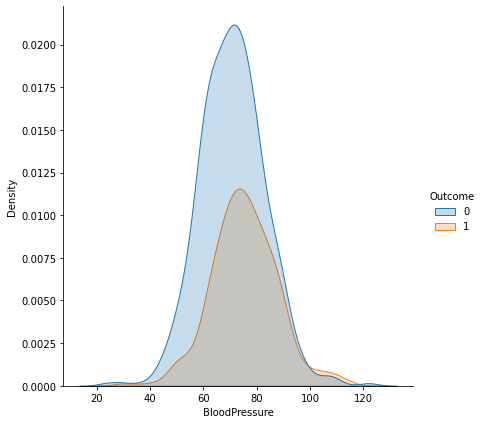

       Com Diabetes  Sem Diabetes
count    252.000000    481.000000
mean      75.321429     70.877339
std       12.299866     12.161223
min       30.000000     24.000000
25%       68.000000     62.000000
50%       74.500000     70.000000
75%       84.000000     78.000000
max      114.000000    122.000000


In [10]:
displot_stats(df, 'BloodPressure')

## 4.3 Dobra Cutânea Triciptal

É medida na face posterior do braço, paralelamente ao eixo longitudinal, no ponto que compreende a metade da distância entre a borda súpero-lateral do acrômio e o olécrano.

A espessura da dobra cutânea tricipal e de um diagnóstico positivo para diabetes apresenta uma correlação positiva fraca. Os valores, já no primeiro quartil para os pacientes com e sem diabetes já distoam bastante.

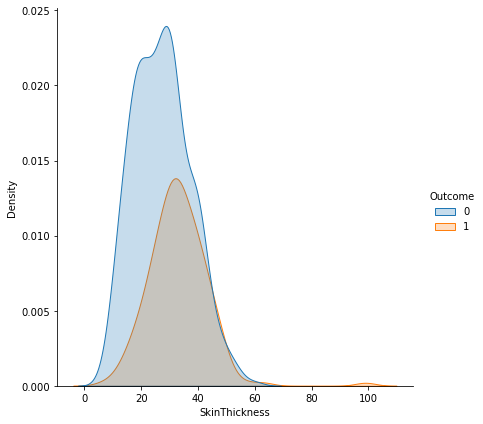

       Com Diabetes  Sem Diabetes
count    180.000000    361.000000
mean      33.000000     27.235457
std       10.327595     10.026491
min        7.000000      7.000000
25%       27.000000     19.000000
50%       32.000000     27.000000
75%       39.000000     33.000000
max       99.000000     60.000000


In [11]:
displot_stats(df, 'SkinThickness')

## 4.4 IMC

O índice de massa corporal (IMC) é uma medida internacional usada para calcular se uma pessoa está no peso ideal. Em adultos:

* Abaixo de 17:	muito abaixo do peso
* Entre 17 e 18.49:	abaixo do peso
* Entre 18.50 e 24.99:	peso normal
* Entre 25 e 29.99:	acima do peso
* Entre 30 e 34.99:	obesidade I
* Entre 35 e 39.99:	obesidade II (severa)
* Acima de 40:	obesidade III (mórbida)

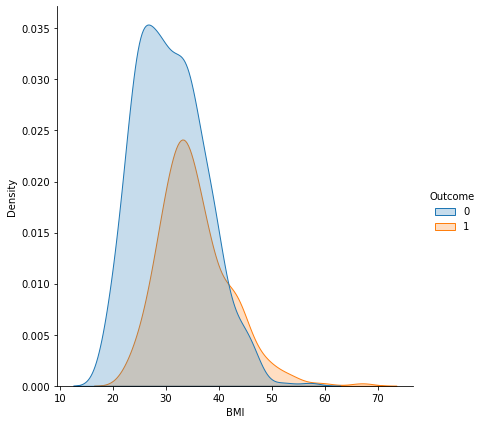

       Com Diabetes  Sem Diabetes
count    266.000000    491.000000
mean      35.406767     30.859674
std        6.614982      6.560737
min       22.900000     18.200000
25%       30.900000     25.600000
50%       34.300000     30.100000
75%       38.925000     35.300000
max       67.100000     57.300000


In [12]:
displot_stats(df, 'BMI')

## 4.5 Diabetes Pedigree Function (DPF)

Esse índice fornece uma síntese histórica de diabetes em parentes e a relação genética desses parentes com o sujeito investigado. Este utiliza informações de pais, avós, irmãos, tias, tios e primos de primeiro grau. Ele fornece uma medida da influência genética esperada de parentes afetados e não afetados no eventual risco de diabetes do sujeito.

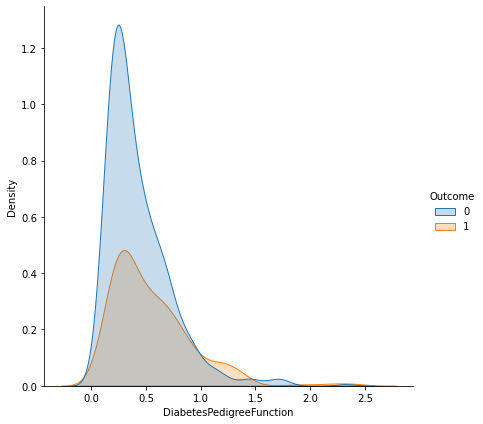

       Com Diabetes  Sem Diabetes
count    268.000000    500.000000
mean       0.550500      0.429734
std        0.372354      0.299085
min        0.088000      0.078000
25%        0.262500      0.229750
50%        0.449000      0.336000
75%        0.728000      0.561750
max        2.420000      2.329000


In [13]:
displot_stats(df, 'DiabetesPedigreeFunction')

## 4.6 Idade

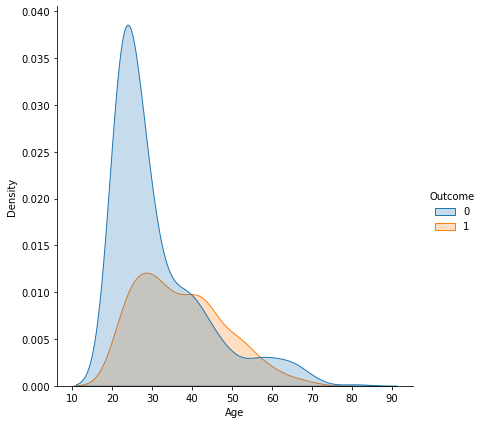

       Com Diabetes  Sem Diabetes
count    268.000000    500.000000
mean      37.067164     31.190000
std       10.968254     11.667655
min       21.000000     21.000000
25%       28.000000     23.000000
50%       36.000000     27.000000
75%       44.000000     37.000000
max       70.000000     81.000000


In [14]:
displot_stats(df, 'Age')

## 4.7 Insulina

A insulina é um hormônio produzido pelo pâncreas. Esse hormônio avisa as células do organismo para que absorvam a glicose

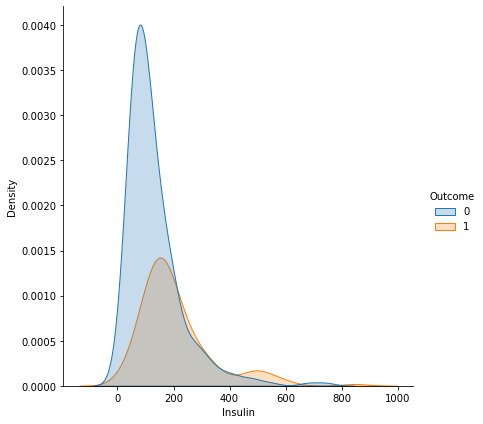

       Com Diabetes  Sem Diabetes
count    130.000000    264.000000
mean     206.846154    130.287879
std      132.699898    102.482237
min       14.000000     15.000000
25%      127.500000     66.000000
50%      169.500000    102.500000
75%      239.250000    161.250000
max      846.000000    744.000000


In [15]:
displot_stats(df, 'Insulin')

# 5.0 Seleção de Variáveis

Antes de selecionar as variáveis para o modelo. Chegou a hora de inputar valores para substituir os valores zerados no nosso dataset.

* Quantidade de zeros em "Glucose": 5.
* Quantidade de zeros em "BloodPressure": 35.
* Quantidade de zeros em "SkinThickness": 227.
* Quantidade de zeros em "Insulin": 374.
* Quantidade de zeros em "BMI": 11.
* Quantidade de zeros em "DiabetesPedigreeFunction": 0.
* Quantidade de zeros em "Age": 0.

Para isso, vou utilizar um critério. Irei separar as variáveis em dois grupos, com diabetes e sem diabetes, e a partir desses dois grupos irei tirar a média. Essa média será utilizada para substituir os valores zerados para cada variável e cada grupo.

In [16]:
# novo dataframe
newdf = df.copy()
newdf = medias(newdf)
newdf.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,1
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1


In [17]:
nomes = list(newdf.columns[1:8])
for nome in nomes:
    size = newdf[newdf[nome] == 0][nome].size
    print('Quantidade de zeros em "{}": {}.'.format(nome, size))

Quantidade de zeros em "Glucose": 0.
Quantidade de zeros em "BloodPressure": 0.
Quantidade de zeros em "SkinThickness": 0.
Quantidade de zeros em "Insulin": 0.
Quantidade de zeros em "BMI": 0.
Quantidade de zeros em "DiabetesPedigreeFunction": 0.
Quantidade de zeros em "Age": 0.


Zeros removidos com sucesso.

Respeitando o princípio de Occam's razor, que diz que explicações mais simples sobre um fenômeno observado devem se sobressair sobre explicações mais complexas, vamos selecionar nossas variáveis. Com isso, iremos evitar a maldição da dimensonalidade e tornar nosso modelo o mais generalizado possível, evitando overfitting.

Existem várias técnicas para a seleção de variáveis, tais como: seleção univariada, eliminação recursiva de atributos, random forest e entre outros. Para esse caso, será utilizado o algoritmo Random Forest. Esse algoritmo atribui uma pontuação de acordo com o grau de importância da variável para a predição do modelo.

In [18]:
# seleção de variáveis.
# split dar features preditoras e targe.
x = newdf.iloc[:, 0:8]
y = newdf.iloc[:, 8]

# criação do modelo.
modelo_selec_var = ExtraTreesClassifier(random_state = 123)
modelo_selec_var.fit(x, y)

# resultados.
resultado_media = pd.DataFrame({'Colunas' : newdf.columns[0:8], 
              'Pontuacao' : modelo_selec_var.feature_importances_}).sort_values('Pontuacao', ascending = False).reset_index(drop = True)

# caputurando as 5 maiores pontuações.
features_media = list(resultado_media.iloc[0:5, 0])

# imprindo as pontuações.
resultado_media

,Colunas,Pontuacao
0,Insulin,0.258454
1,Glucose,0.191197
2,SkinThickness,0.136050
3,BMI,0.100216
4,Age,0.091994
5,DiabetesPedigreeFunction,0.081491
6,Pregnancies,0.075902
7,BloodPressure,0.064696


Note que a 'Insulin' recebeu a maior pontuação dentre as variáveis. Sendo que, ela também recebeu a maior carga de substituição de valores ausentes (quase 50%). 

Da mesma forma a variável 'SkinThickness' também recebeu uma carga bastante considerável de substituições (quase 30%).

Por conta disso, vou refazer o processo e testar a hipótese de que a imputação de valores para essas duas variáveis específicas, possa ter enviesado o cálculo de importância das features.

In [19]:
# Dataset com valores de insulina diferente de 0.
df_sem_zeros = df[df.Insulin > 0]
df_sem_zeros = df_sem_zeros[df_sem_zeros.SkinThickness > 0]
print('Número de linhas no dataset removendo os valores diferente de 0 para "Insulin" e "SkinThickness": {}.'.format(len(df_sem_zeros)))
print('Ou seja, uma redução de {}% do dataset original.'.format(round((100 * len(df_sem_zeros) / len(df)), 2)))

# split dar features preditoras e targe.
x = df_sem_zeros.iloc[:, 0:8]
y = df_sem_zeros.iloc[:, 8]

# criação do modelo.
modelo_selec_var = ExtraTreesClassifier(random_state = 123)
modelo_selec_var.fit(x, y)

# resultados.
resultado_sem_zeros = pd.DataFrame({'Colunas' : df_sem_zeros.columns[0:8], 
              'Pontuacao' : modelo_selec_var.feature_importances_}).sort_values('Pontuacao', 
                                                                                ascending = False).reset_index(drop = True)

# capturando as 5 maiores pontuações.
features_sem_zeros = list(resultado_sem_zeros.iloc[0:5, 0])

resultado_sem_zeros

Número de linhas no dataset removendo os valores diferente de 0 para "Insulin" e "SkinThickness": 394.
Ou seja, uma redução de 51.3% do dataset original.


,Colunas,Pontuacao
0,Glucose,0.222655
1,Age,0.139190
2,Insulin,0.128039
3,BMI,0.108681
4,DiabetesPedigreeFunction,0.107325
5,Pregnancies,0.106448
6,SkinThickness,0.098042
7,BloodPressure,0.089619


Para esse novo dataset, onde foi removido os valores zerados para as variáveis 'Insulin' e 'SkinThickness' a glicemia tornou-se a variável com maior pontuação. A insulina passou a ser apenas a terceira variável e 'SkinThickness' a penúltima. 

Agora vou refazer o processo para os dados brutos.

In [20]:
# dataset bruto

# split dar features preditoras e targe.
x = df.iloc[:, 0:8]
y = df.iloc[:, 8]

# criação do modelo.
modelo_selec_var = ExtraTreesClassifier(random_state = 123)
modelo_selec_var.fit(x, y)

# resultados.
resultado_zeros = pd.DataFrame({'Colunas' : newdf.columns[0:8], 
              'Pontuacao' : modelo_selec_var.feature_importances_}).sort_values('Pontuacao', ascending = False).reset_index(drop = True)

# capturando as 5 maiores pontuações.
features_zeros = list(resultado_zeros.iloc[0:5, 0])

resultado_zeros

,Colunas,Pontuacao
0,Glucose,0.235267
1,BMI,0.141234
2,Age,0.140813
3,DiabetesPedigreeFunction,0.120686
4,Pregnancies,0.111597
5,BloodPressure,0.099123
6,SkinThickness,0.078179
7,Insulin,0.073101


Para o dataset bruto, tanto 'Insulin' quanto 'SkinThickness' receberam potuações que sugerem que essas features, se não tratadas, possuem baixíssima significância para o modelo.

Para o modelo, vou utilizar as variáveis com as 5 maiores pontuações. Além disso, irei realizar fazer o treinamento do modelo para os três casos: dataset com as médias, dataset excluindo os zeros e com o dataset bruto.

# 6.0 Construção do Modelo

Será construído vários modelos de classificação para comparar qual o melhor algoritmo para a execução da tarefa.

## 6.1 Separação em Dados de Treino e Teste

Vou fazer a separação do dataset bruto.

In [21]:
# split dos dados em dados de treino e dados de teste com o dataset bruto.
x_treino, x_teste, y_treino, y_teste = train_test_split(df.iloc[:, 0:8], df['Outcome'], test_size = 0.3, random_state = 123)

# split dos dados em dados de treino e dados de teste com o dataset sem os valores zerados para 'Insulin' e 'SkinThickness'.

x_treino_sem_zeros, x_teste_sem_zeros, y_treino_sem_zeros, y_teste_sem_zeros = train_test_split(df_sem_zeros.iloc[:, 0:8], 
                                                                                                df_sem_zeros['Outcome'], 
                                                                                                test_size = 0.3, 
                                                                                                random_state = 123)

Vou novamente imputar as médias, desta vez nos dataset de treino e teste. Para evitar que informações do dataset de treino vazem para para o dataset de teste e vice-versa.

In [22]:
# substituição dos zeros pelas médias, conforme foi feito anteriormente para dataset de treino e teste.
x_treino_concat = pd.concat([x_treino, pd.DataFrame(y_treino)], axis = 1)
x_treino_medias = medias(x_treino_concat)
y_treino_medias = x_treino_medias['Outcome']
x_treino_medias = x_treino_medias.iloc[:, 0:8]

x_teste_concat = pd.concat([x_teste, pd.DataFrame(y_teste)], axis = 1)
x_teste_medias = medias(x_teste_concat)
y_teste_medias = x_teste_medias['Outcome']
x_teste_medias = x_teste_medias.iloc[:, 0:8]

print('x_treino: {} linhas.\ny_treino: {} linhas.'.format(len(x_treino_medias), len(y_treino_medias)))
print('x_teste: {} linhas.\ny_teste: {} linhas.'.format(len(x_teste_medias), len(y_teste_medias)))

x_treino: 537 linhas.
y_treino: 537 linhas.
x_teste: 231 linhas.
y_teste: 231 linhas.


Agora temos o split de treino e teste para as três condições.

## 6.2 Aplicação da Seleção de Variáveis

Irei aplicar a seleção de variáveis construída na seção 5.0, para os três casos mencionados (com médias, sem os zeros e para os dados brutos).

In [23]:
# com as médias
x_treino_medias = x_treino_medias[features_media] # y_treino_medias
x_teste_medias = x_teste_medias[features_media]   # y_teste_medias

# sem os zeros
x_treino_sem_zeros = x_treino_sem_zeros[features_sem_zeros] # y_treino_sem_zero
x_teste_sem_zeros = x_teste_sem_zeros[features_sem_zeros]   # y_teste_sem_zeros

# dados brutos
x_treino = x_treino[features_zeros] # y_treino
x_teste = x_teste[features_zeros]   # y_teste

## 6.3 Modelos (Algoritmos de Machine Learning)

Vou criar uma lista e adicionar todos os modelos que irei utilizar.

In [24]:
# lista com todos os modelos.
modelos = []

modelos.append(('RF', RandomForestClassifier()))
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('SVM', SVC()))
modelos.append(('XGB', XGBClassifier()))

modelos

[('RF', RandomForestClassifier()),
 ('LR', LogisticRegression()),
 ('LDA', LinearDiscriminantAnalysis()),
 ('NB', GaussianNB()),
 ('KNN', KNeighborsClassifier()),
 ('SVM', SVC()),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=None))]

## 6.4 Treinamento

Agora irei treinar o modelo com os dados de treino e medir a acurácia do modelo com os dados de teste, para as três situações já mencionadas anteriormente. Para isso, irei treinar o modelo com e sem nenhuma transformação nos dados.

O ato de transformação dos dados serve para que o algoritmo não fique enviesado devidos a diferença de escala entre os valores das variáveis. Além disso, alguns algoritmos esperam receber os dados em uma mesma escala ou em distribuição normal.

Vou fazer três tipos de transformação nos dados: normalização com MinMaxScaler() e Normalizer() e padronização com StandardScale(). No final irei comparar e escolher o com maior acuária.

A normalização transforma os dados para que eles fiquem dentro de um range, que nesse caso será de 0 à 1. A padronização transforma nossos dados para uma distribuição Gaussiana (normal) com média = 0 e desvio padrão = 1.

### 6.4.1 Sem Transformação

In [25]:
# dados bruto
result_bruto = fit_modelos(modelos, x_treino, y_treino, x_teste, y_teste)

# dados sem os zeros
result_sem_zeros = fit_modelos(modelos, x_treino_sem_zeros, y_treino_sem_zeros, 
                                 x_teste_sem_zeros, y_teste_sem_zeros)

# dados com as médias
result_medias = fit_modelos(modelos, x_treino_medias, y_treino_medias, x_teste_medias, y_teste_medias)

# unindo os resultados
resultados_sem_trans = concat_results(result_bruto, result_sem_zeros, result_medias)
resultados_sem_trans

,RF,LR,LDA,NB,KNN,SVM,XGB,MEDIAS
Dados Bruto,77.06,79.65,80.09,77.06,74.46,77.92,75.76,77.43
Sem Zeros,81.51,79.83,80.67,76.47,70.59,78.99,78.15,78.03
Com Médias,82.68,80.09,81.39,83.98,70.13,86.15,78.35,80.40
Médias,80.42,79.86,80.72,79.17,71.73,81.02,77.42,78.62


### 6.4.2 Com Normalização (MinMaxScaler)

In [26]:
# dados bruto
x_treino_norm1_bruto = min_max_scaler(x_treino)
x_teste_norm1_bruto  = min_max_scaler(x_teste)
result_bruto_norm1   = fit_modelos(modelos, x_treino_norm1_bruto, y_treino, x_teste_norm1_bruto, y_teste)

# dados sem os zeros
x_treino_norm1_sem_zeros = min_max_scaler(x_treino_sem_zeros)
x_teste_norm1_sem_zeros  = min_max_scaler(x_teste_sem_zeros)
result_sem_zeros_norm1   = fit_modelos(modelos, x_treino_norm1_sem_zeros, y_treino_sem_zeros, 
                                       x_teste_norm1_sem_zeros, y_teste_sem_zeros)

# dados com as médias
x_treino_norm1_medias = min_max_scaler(x_treino_medias)
x_teste_norm1_medias  = min_max_scaler(x_teste_medias)
result_medias_norm1   = fit_modelos(modelos, x_treino_norm1_medias, y_treino_medias, 
                                    x_teste_norm1_medias, y_teste_medias)

# unindo os resultados
resultados_norm1 = concat_results(result_bruto_norm1, result_sem_zeros_norm1, result_medias_norm1)
resultados_norm1

,RF,LR,LDA,NB,KNN,SVM,XGB,MEDIAS
Dados Bruto,77.06,76.19,79.22,77.49,74.89,77.92,75.76,76.93
Sem Zeros,73.95,81.51,81.51,78.15,73.11,75.63,71.43,76.47
Com Médias,83.55,74.46,76.62,76.19,72.29,75.76,83.12,77.43
Médias,78.19,77.39,79.12,77.28,73.43,76.44,76.77,76.94


### 6.4.3 Com Normalização (Normalizer)

In [27]:
# dados bruto
x_treino_norm2_bruto = normalizer(x_treino)
x_teste_norm2_bruto  = normalizer(x_teste)
result_bruto_norm2   = fit_modelos(modelos, x_treino_norm2_bruto, y_treino, x_teste_norm2_bruto, y_teste)

# dados sem os zeros
x_treino_norm2_sem_zeros = normalizer(x_treino_sem_zeros)
x_teste_norm2_sem_zeros  = normalizer(x_teste_sem_zeros)
result_sem_zeros_norm2   = fit_modelos(modelos, x_treino_norm2_sem_zeros, y_treino_sem_zeros, 
                                       x_teste_norm2_sem_zeros, y_teste_sem_zeros)

# dados com as médias
tipo_dado = 'Com Médias'
x_treino_norm2_medias = normalizer(x_treino_medias)
x_teste_norm2_medias  = normalizer(x_teste_medias)
result_medias_norm2   = fit_modelos(modelos, x_treino_norm2_medias, y_treino_medias, 
                                    x_teste_norm2_medias, y_teste_medias)

# unindo os resultados
resultados_norm2 = concat_results(result_bruto_norm2, result_sem_zeros_norm2, result_medias_norm2)
resultados_norm2

,RF,LR,LDA,NB,KNN,SVM,XGB,MEDIAS
Dados Bruto,68.83,61.9,65.8,63.2,61.04,61.9,64.94,63.94
Sem Zeros,64.71,67.23,63.87,58.82,66.39,71.43,65.55,65.43
Com Médias,78.79,62.77,64.94,78.79,76.62,61.9,74.46,71.18
Médias,70.78,63.97,64.87,66.94,68.02,65.08,68.32,66.85


### 6.4.4 Padronização (StandardScale)

In [28]:
# dados bruto
x_treino_std_bruto = standarization(x_treino)
x_teste_std_bruto  = standarization(x_teste)
result_bruto_std   = fit_modelos(modelos, x_treino_std_bruto, y_treino, x_teste_std_bruto, y_teste)

# dados sem os zeros
x_treino_std_sem_zeros = standarization(x_treino_sem_zeros)
x_teste_std_sem_zeros  = standarization(x_teste_sem_zeros)
result_sem_zeros_std   = fit_modelos(modelos, x_treino_std_sem_zeros, y_treino_sem_zeros, 
                                     x_teste_std_sem_zeros, y_teste_sem_zeros)

# dados com as médias
x_treino_std_medias = standarization(x_treino_medias)
x_teste_std_medias  = standarization(x_teste_medias)
result_medias_std   = fit_modelos(modelos, x_treino_std_medias, y_treino_medias, 
                                  x_teste_std_medias, y_teste_medias)

# unindo os resultados
resultados_std = concat_results(result_bruto_std, result_sem_zeros_std, result_medias_std)
resultados_std

,RF,LR,LDA,NB,KNN,SVM,XGB,MEDIAS
Dados Bruto,75.32,79.65,80.09,77.49,74.03,76.19,74.03,76.69
Sem Zeros,80.67,79.83,81.51,77.31,70.59,77.31,77.31,77.79
Com Médias,85.71,81.82,81.82,82.68,88.31,87.01,82.68,84.29
Médias,80.57,80.43,81.14,79.16,77.64,80.17,78.01,79.59


### 6.4.5 Destaques

#### Dados sem transformação

* Os dados que receberam as médias apresentaram as melhores acurácias em relação aos demais.
* Os dados brutos apresentaram as piores acurácias em relação aos demais.
* SVM apresentou a melhor acurácia dentre os modelos.
* KNN apresentou a pior acurácia dentro os modelos.

#### Transformação com MinMaxScaler()

* No geral as acurácias apresentaram uma piora em relação aos dados sem transformação.
* RF e XGBoost obteve um ganho considerável de acurácia para os dados com as médias.

#### Transformação com Normalizer()

* No geral houve uma redução muito significativa da acuária dos modelos.
* Apenas NB e KNN, com as médias, conseguiram melhorar a acurácia em relação a normalização com MinMaxScaler.

#### Padronização

* Os dados brutos e os dados sem os zeros manteram praticamente as acurácias do treinamento sem transformação.
* Os dados com as médias apresentaram uma melhora bastante significativa em relação as outras transformações.
* KNN e SVM com as médias obtiveram a melhor acurácia dentre todos.

# 7.0 Otimizando o Modelo

Irei realizar um processo de otimização do algoritmo, buscando aumentar ainda mais a acurácia do modelo. Irei realizar esse procedimento nos dois algoritmos que apresentaram maior acurácia até o momento, SVM e KNN (com médias e padronização). 

## 7.1 SVM Tuning

In [29]:
# hyperparâmetros e seus valores que serão utilizados para testar o modelo.
hyper_svm = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
               'gamma': [1, 0.1, 0.01, 0.001], 
               'kernel': ['rbf', 'poly', 'sigmoid']}

# modelo.
modelo_svm = SVC()

# otimizador.
tuning_svm = RandomizedSearchCV(estimator           = modelo_svm, 
                                param_distributions = hyper_svm,
                                n_iter              = 15,
                                random_state        = 123,
                                scoring             = 'roc_auc')

# rodando o otimizador.
tuning_svm.fit(x_treino_std_medias, y_treino)

# resultados.
print('Melhores Parâmetros do Modelo: \n', tuning_svm.best_estimator_)

Melhores Parâmetros do Modelo: 
 SVC(C=10, gamma=0.1)


Acurácia do modelo otimizado: 87.45%.

Confusion Matrix:
 [[130  13]
 [ 16  72]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       143
           1       0.85      0.82      0.83        88

    accuracy                           0.87       231
   macro avg       0.87      0.86      0.87       231
weighted avg       0.87      0.87      0.87       231



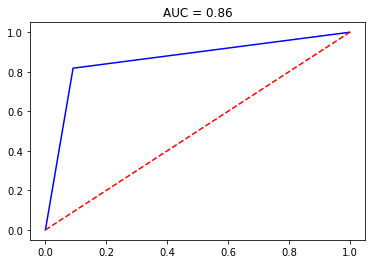

In [30]:
# modelo otimizado
modelo_svm = SVC(C = 10, gamma = 0.1)
modelo_svm.fit(x_treino_std_medias, y_treino)
print('Acurácia do modelo otimizado: {}%.'.format(round(100 * (modelo_svm.score(x_teste_std_medias, y_teste)), 2)))

# previsões
y_hat_svm = modelo_svm.predict(x_teste_std_medias)

# confusion matrix
conf_mtx_svm = confusion_matrix(y_teste, y_hat_svm)
class_report_svm = classification_report(y_teste, y_hat_svm)
print('\nConfusion Matrix:\n', conf_mtx_svm)
print('\nRelatório de Classificação:\n', class_report_svm)

# curva roc
fpr_svm, tpr_svm, x = roc_curve(y_teste, y_hat_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.title('AUC = %0.2f' % roc_auc_svm)
plt.plot(fpr_svm, tpr_svm, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.show()

## 7.2 KNN Tuning

In [31]:
# hyperparâmetros e seus valores que serão utilizados para testar o modelo.
hyper_knn = {'leaf_size'   : list(range(1,50)),
               'n_neighbors' : list(range(1,30)),
               'p'           : [1, 2],
               'weights'     : ['uniform', 'distance'],
               'algorithm'   : ['auto', 'ball_tree','kd_tree','brute']}

# modelo.
modelo_knn = KNeighborsClassifier()

# otimizador.
tuning_knn = RandomizedSearchCV(estimator           = modelo_knn, 
                                param_distributions = hyper_knn,
                                n_iter              = 15,
                                random_state        = 123,
                                scoring             = 'roc_auc')

# rodando o otimizador.
tuning_knn.fit(x_treino_std_medias, y_treino)

# resultado.
print('Melhores Parâmetros do Modelo: \n', tuning_knn.best_estimator_)

Melhores Parâmetros do Modelo: 
 KNeighborsClassifier(algorithm='brute', leaf_size=45, n_neighbors=22, p=1,
                     weights='distance')


Acurácia do modelo otimizado: 90.04%.

Confusion Matrix:
 [[133  10]
 [ 13  75]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       143
           1       0.88      0.85      0.87        88

    accuracy                           0.90       231
   macro avg       0.90      0.89      0.89       231
weighted avg       0.90      0.90      0.90       231



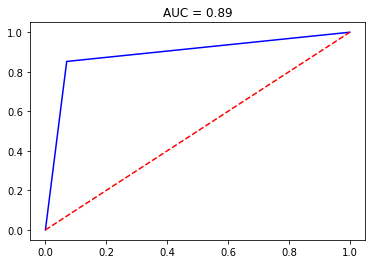

In [32]:
# modelo otimizado
modelo_knn = KNeighborsClassifier(algorithm = 'brute', leaf_size = 45, n_neighbors = 22, p = 1, weights = 'distance')
modelo_knn.fit(x_treino_std_medias, y_treino)
print('Acurácia do modelo otimizado: {}%.'.format(round(100 * (modelo_knn.score(x_teste_std_medias, y_teste)), 2)))

# previsões
y_hat_knn = modelo_knn.predict(x_teste_std_medias)

# confusion matrix
conf_mtx_knn = confusion_matrix(y_teste, y_hat_knn)
class_report_knn = classification_report(y_teste, y_hat_knn)
print('\nConfusion Matrix:\n', conf_mtx_knn)
print('\nRelatório de Classificação:\n', class_report_knn)

# curva roc
fpr_knn, tpr_knn, x = roc_curve(y_teste, y_hat_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.title('AUC = %0.2f' % roc_auc_knn)
plt.plot(fpr_knn, tpr_knn, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.show()

# 8.0 Conclusões

* O modelo possui baixa correlação entre as variáveis preditora e a variável target. 

* A média das acurácias para os modelos com os dados com as médias foram melhores em todas as situações.

* A padronização dos dados garantiu melhor acurácia dos modelos.

* KNN apresentou uma melhora bastante significativa com a padronização, e obteve a melhor acurácia de todos os modelos treinados.

* Não foi possível otimizar o modelo SVM com os parâmetros escolhidos.

* O modelo KNN apresentou uma boa melhora com a otimização realizada, saindo de 88.31% para 90.04%.